In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import notebook
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import copy
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv


### Analyze Data

In [40]:
#loading dataframe
df = pd.read_csv(dirname + "/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


To make a quick neural network using the data above,<br>
we can easily create a neural network using the following the columns:<br>
'**Age**', '**Sex**', '**Fare**', '**Pclass**', '**SibSp**', '**Parch**'

In [41]:
# function to filter the age, sex, fare pclass, sibsp, parch columns
def get_data(data):
    # take only this specific column
    data = data[['Age', 'Sex', 'Fare', 'Pclass', 'SibSp', 'Parch']]
    
    # replace male by 1, female by 0
    data.replace({ 'male' : 1, 'female' : 0 }, inplace=True)
    
    # replace null/nan data by the mean (age and fare columns)
    data['Fare'].fillna(int(data['Fare'].mean()), inplace=True)
    data['Age'].fillna(int(data['Age'].mean()), inplace=True)
    
    
    # transform into a numpy array
    data = data.to_numpy()
    
    # normalize (make sure the data is between -1 and 1)
    for i in range(data.shape[1]):
        data[:,i] = (data[:,i] - data[:,i].mean()) / data[:,i].std()
    
    return data

In [42]:
# lets take out first the label
y=df['Survived'].values
#print(y.shape)-->(891,)
#y_binarized is used just stratifying the data in train_test_split
df['Survived'].value_counts(normalize=True)#ensures all 0,1's are in equal ratio
y_binarized=df['Survived'].values
#print(y_binarized)

#loading data into x
x= get_data(df)
#print(x.shape)--->(891,6)

#splitting data for evaluation and training  x_train,y_train --->training purpose y_test,x_test--->valuation purpose
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,stratify=y_binarized)
#print(x_train.shape)-->(668,6)
#print(x_test.shape)-->(223,6)
#print(y_train.shape)-->(668,)
#print(y_test.shape)-->(223,)

#converting numpy arrays into tensors using pytorch
x_torch_train=torch.from_numpy(x_train)
y_torch_trian=torch.from_numpy(y_train)
x_torch_test=torch.from_numpy(x_test)
y_torch_test=torch.from_numpy(y_test)

# Neural Network
### Network consists of 10 layers: 
        1)Linear(in_features=6, out_features=512, bias=True)
        2)ELU(alpha=1.0)
        3)Linear(in_features=512, out_features=128, bias=True)
        4)ELU(alpha=1.0)
        5)Linear(in_features=128, out_features=18, bias=True)
        6)ELU(alpha=1.0)
        7)Linear(in_features=18, out_features=6, bias=True)
        8)ELU(alpha=1.0)
        9)Linear(in_features=6, out_features=1, bias=True)
        10)Sigmoid()
***Loss Function*** is ***Binary CrossEntropyLoss(BCELoss)***<br>
***Optimization Function*** is ***Adam() with learning rate=0.00125***(given manually)

In [57]:
#This class is used to to create above network
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.net=nn.Sequential(
                                nn.Linear(6,512),
                                nn.ELU(),
                                nn.Linear(512,128),
                                nn.ELU(),
                                nn.Linear(128,18),
                                nn.ELU(),
                                nn.Linear(18,6),
                                nn.ELU(),
                                nn.Linear(6,1),
                                nn.Sigmoid()
                                )
    def forward(self,X):
        return self.net(X)[:,0]
    #Fit function is used to iterate over train data and update parameters    
    def fit(self,X,Y,optimizer=0,loss_fn=nn.BCELoss(),epochs=1000):
        loss_arr=[]
        min_loss=0.3
        if optimizer == 0:
            optimizer=optim.Adam(self.net.parameters())
        for i in notebook.tqdm(range(epochs),total=epochs,unit='epoch'):
            loss=loss_fn(self(X),Y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_arr.append(loss.item())
            if min_loss > loss.item():
                min_loss = loss.item()
                best_model = copy.deepcopy(self.state_dict())
        print('========================')
        print('     Min loss %0.2f' % min_loss)
        print('========================')
        self.load_state_dict(best_model)
        return loss_arr
    #calaculate accuracy after training the data
    def accuracy(self,X,Y):
        correct=0
        total=0
        bin_train=self(X)
        bin_train=(bin_train>0.5).int()
        Y=Y.int()
        for i,j in zip(bin_train,Y):
            total+=1
            if i==j:
                correct+=1
        accuracy=100*(correct/total)
        print('total =',total)
        print('correct predictions =',correct)
        print('accuracy =',round(accuracy,2))

In [58]:
#intializing model and moving all data to gpu
model=Network()
device=torch.device("cuda")
print(device)
x_torch_train=x_torch_train.to(device)
y_torch_trian=y_torch_trian.to(device)
x_torch_test=x_torch_test.to(device)
y_torch_test=y_torch_test.to(device)
model.to(device)

cuda


Network(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=512, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=18, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=18, out_features=6, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=6, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [ ]:
#test model is working properly or not
pred=model(tensor_train_x.float())
print(pred)

### Training The model


     Min loss 0.09
----------Train Accuracy---------- 
total = 668
correct predictions = 638
accuracy = 95.51
----------Test  Accuracy---------- 
total = 223
correct predictions = 174
accuracy = 78.03


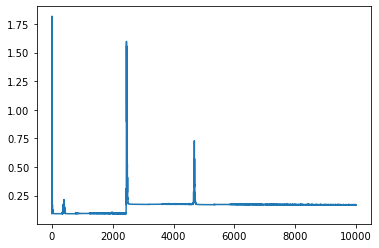

In [60]:
#loss_fn=nn.BCELoss()
#optimizer=optim.Adam(model.parameters())---->#specifiy learning rate if you prefer using lr=learning_rate_value
losslist=model.fit(x_torch_train.float(),y_torch_trian.float(),epochs=10000)
print('----------Train Accuracy---------- ')
model.accuracy(x_torch_train.float(),y_torch_trian.float())
print('----------Test  Accuracy---------- ')
model.accuracy(x_torch_test.float(),y_torch_test.float())
plt.plot(losslist)
plt.show()

# Make predictions on test DATA

In [61]:
test_df = pd.read_csv(dirname + "/test.csv")
test_x = get_data(test_df)
torch_test_x=torch.from_numpy(test_x)
torch_test_x=torch_test_x.to(device)

In [62]:
# Get test data predictions
test_preds =model(torch_test_x.float())
test_preds=(test_preds>0.5).int()
test_preds=test_preds.tolist()


In [63]:
# Add passengers ids to the test predictions
passenger_ids = test_df['PassengerId'].to_numpy()

In [64]:
# combine passenger ids with the predictions
final_result = np.array(list(map(list, zip(passenger_ids, test_preds))))

In [65]:
# arraay final_result to dataframe
df_final = pd.DataFrame(data=final_result, columns=["PassengerId", "Survived"])
# save the result
#df_final.tail()
df_final.to_csv('submission_final10.csv', index=False)